# Greater Sydney Analysis – SA4 Blacktown

## 0 Setup

In [65]:
# Python imports
import os, json, time, requests
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine, text, inspect

# Database connection
DB_URL = "postgresql+psycopg2://root:pg@localhost:5432/gsa"
engine = create_engine(DB_URL, future=True)
inspector = inspect(engine)

with engine.begin() as conn:
    conn.exec_driver_sql("""
        CREATE SCHEMA IF NOT EXISTS raw;
        CREATE SCHEMA IF NOT EXISTS analysis;
    """)

## TASK 1
### 1.1 Load raw data (shapefile & CSV)
Load national SA2 shapefile and raw CSV tables. Skip if tables already exist.

In [66]:
# Paths to raw files
SHAPEFILE = "./data_raw/SA2_2021_AUST_GDA2020/SA2_2021_AUST_GDA2020.shp"
BUSINESSES_CSV = "./data_raw/Businesses.csv"
POP_CSV = "./data_raw/Population.csv"
INCOME_CSV = "./data_raw/Income.csv"
STOPS_TXT = "./data_raw/Stops.txt"
PRIMARY_SHP = "./data_raw/catchments/catchments_primary.shp"
SECONDARY_SHP = "./data_raw/catchments/catchments_secondary.shp"

# Load national SA2 shapefile
if not inspector.has_table("sa2_all", schema="raw"):
    gdf_sa2 = gpd.read_file(SHAPEFILE).to_crs(7844)
    gdf_sa2.to_postgis(
        "sa2_all", engine, schema="raw", if_exists="replace", index=False
    )
    print("Loaded raw.sa2_all")
else:
    print("raw.sa2_all already exists - skipping")

# Load CSV tables
csv_map = {"businesses": BUSINESSES_CSV, "population": POP_CSV, "income": INCOME_CSV}

for name, path in csv_map.items():
    if not inspector.has_table(name, schema="raw"):
        pd.read_csv(path).to_sql(
            name,
            engine,
            schema="raw",
            if_exists="replace",
            index=False,
            chunksize=10000,
        )
        print(f"Loaded raw.{name}")
    else:
        print(f"raw.{name} already exists - skipping")

# Load Stops.txt, build geometry
if not inspector.has_table("stops", schema="raw"):
    stops = pd.read_csv(STOPS_TXT)
    gdf_stops = gpd.GeoDataFrame(
        stops, geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat, crs=4326)
    ).to_crs(7844)
    gdf_stops.to_postgis(
        "stops", engine, schema="raw", if_exists="replace", index=False
    )
    print("Loaded raw.stops")
else:
    print("raw.stops already exists - skipping")

# Load primary‐school catchments
if not inspector.has_table("catchments_primary", schema="raw"):
    gdf_primary = gpd.read_file(PRIMARY_SHP).to_crs("EPSG:7844")
    gdf_primary.to_postgis(
        name="catchments_primary",
        con=engine,
        schema="raw",
        if_exists="replace",
        index=False,
    )
    print("Loaded raw.catchments_primary")
else:
    print("raw.catchments_primary exists — skipping")

# Load secondary‐school catchments
if not inspector.has_table("catchments_secondary", schema="raw"):
    gdf_secondary = gpd.read_file(SECONDARY_SHP).to_crs("EPSG:7844")
    gdf_secondary.to_postgis(
        name="catchments_secondary",
        con=engine,
        schema="raw",
        if_exists="replace",
        index=False,
    )
    print("Loaded raw.catchments_secondary")
else:
    print("raw.catchments_secondary exists — skipping")


raw.sa2_all already exists - skipping
raw.businesses already exists - skipping
raw.population already exists - skipping
raw.income already exists - skipping
raw.stops already exists - skipping
raw.catchments_primary exists — skipping
raw.catchments_secondary exists — skipping


### 1.2 Filter to **Blacktown** SA4
Create *_my tables limited to the chosen SA4.

In [67]:
# Slice everything to the chosen Blacktown SA4
with engine.begin() as conn:
    # Create a clean Blacktown‑only SA2 table
    conn.exec_driver_sql(
        """
        DROP TABLE IF EXISTS raw.sa2_my;
        CREATE TABLE raw.sa2_my AS
        SELECT "SA2_CODE21" AS sa2_code21,
               "SA2_NAME21" AS sa2_name21,
               geometry
        FROM   raw.sa2_all
        WHERE  "SA4_NAME21" = 'Sydney - Blacktown';

        CREATE INDEX IF NOT EXISTS idx_sa2_my_geom
            ON raw.sa2_my USING gist (geometry);
    """
    )

    # Filter each national CSV table down to Blacktown SA2 rows
    for name in csv_map.keys():
        sa2_col = "sa2_code21" if name == "income" else "sa2_code"

        # If the column is already sa2_code21, keep it as‑is; otherwise alias it
        select_extra = (
            "" if sa2_col == "sa2_code21" else f", t.{sa2_col}::text AS sa2_code21"
        )

        conn.exec_driver_sql(
            f"""
            DROP TABLE IF EXISTS raw.{name}_my CASCADE;
            CREATE TABLE raw.{name}_my AS
            SELECT t.*{select_extra}
            FROM   raw.{name} t
            JOIN   raw.sa2_my s
            ON   t.{sa2_col}::text = s.sa2_code21;
        """
        )

        # Spatially filter GTFS stops to the Blacktown
        conn.exec_driver_sql(
            """
            DROP TABLE IF EXISTS raw.stops_my CASCADE;
            CREATE TABLE raw.stops_my AS
            SELECT s.*
            FROM   raw.stops s
            JOIN   raw.sa2_my a
            ON   ST_Contains(a."geometry", s."geometry");  -- both use "geometry"

            CREATE INDEX IF NOT EXISTS idx_stops_my_geom
                ON raw.stops_my USING gist ("geometry");
        """
        )

            # … your existing for‐loop and stops filter here …

    # 🔹 Spatially filter primary & secondary catchments to Blacktown
        conn.exec_driver_sql("""
            DROP TABLE IF EXISTS raw.catchments_primary_my CASCADE;
            CREATE TABLE raw.catchments_primary_my AS
            SELECT c.*
            FROM raw.catchments_primary AS c
            JOIN raw.sa2_my             AS s
            ON ST_Intersects(s.geometry, c.geometry);
            CREATE INDEX IF NOT EXISTS idx_catchments_primary_my_geom
                ON raw.catchments_primary_my USING gist (geometry);

            DROP TABLE IF EXISTS raw.catchments_secondary_my CASCADE;
            CREATE TABLE raw.catchments_secondary_my AS
            SELECT c.*
            FROM raw.catchments_secondary AS c
            JOIN raw.sa2_my               AS s
            ON ST_Intersects(s.geometry, c.geometry);
            CREATE INDEX IF NOT EXISTS idx_catchments_secondary_my_geom
                ON raw.catchments_secondary_my USING gist (geometry);
        """)


print("Blacktown slices created")

Blacktown slices created


## TASK 2
### 2.1 POI API extraction

In [68]:
LAYER_URL = (
    "https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query"
)

FIELD_LIST = ",".join([
    "objectid",
    "poigroup",
    "poitype",
    "poiname",
    "poilabel",
    "poialtlabel",
])


def fetch_poi_bbox(bbox, chunk=1000):
    params = {
        "geometry": ",".join(map(str, bbox)),
        "geometryType": "esriGeometryEnvelope",
        "inSR": 4326,
        "outSR": 4326,
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": FIELD_LIST,
        "returnGeometry": "true",
        "where": "1=1",
        "f": "json",
        "resultRecordCount": chunk,
    }

    records, offset = [], 0
    while True:
        params["resultOffset"] = offset
        resp = requests.get(LAYER_URL, params=params, timeout=40)
        resp.raise_for_status()
        feats = resp.json().get("features", [])
        records.extend(feats)
        if len(feats) < chunk:
            break
        offset += chunk
        time.sleep(0.3)
    return records

### 2.2 Loop through every Blacktown SA2

In [69]:
# Load SA2 polygons and convert to EPSG:4326
sa2 = gpd.read_postgis(
    "SELECT sa2_code21, geometry FROM raw.sa2_my", engine, geom_col="geometry"
).to_crs(4326)

# Define the mapping
POI_GROUP_MAP = {
    1: "Community",
    2: "Education",
    3: "Recreation",
    4: "Transport",
    5: "Utility",
    6: "Hydrography",
    7: "Landform",
    8: "Place",
    9: "Industry",
}
rows = []

for _, row in sa2.iterrows():
    print(f"Fetching POIs for SA2 {row.sa2_code21}")
    feats = fetch_poi_bbox(row.geometry.bounds)

    for f in feats:
        attr = f["attributes"]

        # Some poiname return null
        name = attr.get("poiname") or attr.get("poilabel") or attr.get("poialtlabel")

        # 2. Translate the integer code to a name
        code = attr.get("poigroup")
        grp  = POI_GROUP_MAP.get(code, f"Unknown({code})")

        rows.append(
            {
                "sa2_code21": row.sa2_code21,
                "poi_group":  grp,
                "poi_type": attr.get("poitype"),
                "name": name,
                "longitude": f["geometry"]["x"],
                "latitude": f["geometry"]["y"],
            }
        )

    # wait before next SA2
    time.sleep(1)

print(f"Finished — collected {len(rows):,} POI records")

# print(rows[0])

Fetching POIs for SA2 116011303
Fetching POIs for SA2 116011304
Fetching POIs for SA2 116011306
Fetching POIs for SA2 116011307
Fetching POIs for SA2 116011560
Fetching POIs for SA2 116011561
Fetching POIs for SA2 116011626
Fetching POIs for SA2 116011627
Fetching POIs for SA2 116021309
Fetching POIs for SA2 116021562
Fetching POIs for SA2 116021563
Fetching POIs for SA2 116021628
Fetching POIs for SA2 116021629
Fetching POIs for SA2 116021630
Fetching POIs for SA2 116021631
Fetching POIs for SA2 116021632
Fetching POIs for SA2 116021633
Fetching POIs for SA2 116031313
Fetching POIs for SA2 116031314
Fetching POIs for SA2 116031315
Fetching POIs for SA2 116031316
Fetching POIs for SA2 116031317
Fetching POIs for SA2 116031318
Fetching POIs for SA2 116031319
Finished — collected 2,747 POI records


### 2.3 Ingest Result Into Postgres

In [70]:
# Convert rows to GeoDataFrame
gdf_poi = gpd.GeoDataFrame(
    rows,
    geometry=gpd.points_from_xy(
        [r["longitude"] for r in rows], [r["latitude"] for r in rows]
    ),
    crs="EPSG:4326",
).to_crs("EPSG:7844")

# Filter columns
gdf_poi = gdf_poi[["sa2_code21", "poi_group","poi_type", "name", "geometry"]]

# Save to PostGIS
gdf_poi.to_postgis(
    name="poi_my", con=engine, schema="raw", if_exists="replace", index=False
)

# Create spatial index
with engine.begin() as conn:
    conn.exec_driver_sql(
        """
        CREATE INDEX IF NOT EXISTS idx_poi_my_geom
        ON raw.poi_my USING gist (geometry);
    """
    )

print(f"raw.poi_my table created with {len(gdf_poi):,} rows")

raw.poi_my table created with 2,747 rows


## TASK 3
### 3.1 Metric-level materialised views

In [72]:
with engine.begin() as conn:
    conn.exec_driver_sql("""
        /* 🔹 Businesses per 1 000 residents */
        CREATE OR REPLACE VIEW analysis.vw_metric_business AS
        SELECT
            b.sa2_code21,
            SUM(b.total_businesses)::numeric
              / NULLIF(MAX(p.total_people), 0) * 1000 AS biz_per_1k
        FROM raw.businesses_my  AS b
        JOIN raw.population_my  AS p USING (sa2_code21)
        WHERE b.industry_name IN (
            'Health Care & Social Assistance',
            'Retail Trade',
            'Education & Training'
        )
        GROUP BY b.sa2_code21;

        /* 🔹 Public-transport stops (raw count) */
        CREATE OR REPLACE VIEW analysis.vw_metric_stops AS
        SELECT
            s.sa2_code21,
            COUNT(*)::numeric AS stops_raw
        FROM raw.stops_my AS st
        JOIN raw.sa2_my   AS s
          ON ST_Contains(s.geometry, st.geometry)
        GROUP BY s.sa2_code21;

        /* 🔹 POIs in resource-signalling groups (raw count) */
        CREATE OR REPLACE VIEW analysis.vw_metric_poi AS
        SELECT
            p.sa2_code21,
            COUNT(*)::numeric AS poi_raw
        FROM raw.poi_my AS p
        WHERE p.poi_group IN ('Medical','Shopping','Recreation')
        GROUP BY p.sa2_code21;

 /* 🔹 Schools per 1 000 youth (ages 0–19) */
        DROP VIEW IF EXISTS analysis.vw_metric_schools CASCADE;

        CREATE OR REPLACE VIEW analysis.vw_metric_schools AS
        SELECT
            pop.sa2_code21,
            (COALESCE(pr.count_pri,0) + COALESCE(sec.count_sec,0))::numeric
              / NULLIF(
                  pop."0-4_people"
                + pop."5-9_people"
                + pop."10-14_people"
                + pop."15-19_people"
                , 0
              ) * 1000 AS schools_per_1k_youth
        FROM raw.population_my AS pop

        /* count primary catchments via spatial join */
        LEFT JOIN (
            SELECT
              s.sa2_code21,
              COUNT(*) AS count_pri
            FROM raw.catchments_primary_my AS c
            JOIN raw.sa2_my              AS s
              ON ST_Intersects(c.geometry, s.geometry)
            GROUP  BY s.sa2_code21
        ) AS pr
          ON pr.sa2_code21 = pop.sa2_code21

        /* count secondary catchments via spatial join */
        LEFT JOIN (
            SELECT
              s.sa2_code21,
              COUNT(*) AS count_sec
            FROM raw.catchments_secondary_my AS c
            JOIN raw.sa2_my                AS s
              ON ST_Intersects(c.geometry, s.geometry)
            GROUP  BY s.sa2_code21
        ) AS sec
          ON sec.sa2_code21 = pop.sa2_code21;
    """)



## 3.2 Merge everything into a single per-SA2 view

In [73]:
with engine.begin() as conn:
    conn.exec_driver_sql("""
        DROP VIEW IF EXISTS analysis.vw_sa2_metrics CASCADE;

        CREATE VIEW analysis.vw_sa2_metrics AS
        SELECT
            s.sa2_code21,
            COALESCE(b.biz_per_1k,        0) AS business,
            COALESCE(t.stops_raw,         0) AS stops,
            COALESCE(p.poi_raw,           0) AS poi,
            COALESCE(sch.schools_per_1k_youth, 0) AS schools,
            pop.total_people
        FROM raw.sa2_my               AS s
        LEFT JOIN analysis.vw_metric_business AS b USING (sa2_code21)
        LEFT JOIN analysis.vw_metric_stops    AS t USING (sa2_code21)
        LEFT JOIN analysis.vw_metric_poi      AS p USING (sa2_code21)
        LEFT JOIN analysis.vw_metric_schools  AS sch USING (sa2_code21)
        LEFT JOIN raw.population_my           AS pop USING (sa2_code21)
        WHERE pop.total_people >= 100;   -- drop tiny SA2s
    """)



## 3.3 Z-scores via window functions

In [74]:
with engine.begin() as conn:
    conn.exec_driver_sql("""
        /* Drop the old one (view not mat-view) if it exists */
        DROP VIEW IF EXISTS analysis.vw_sa2_zscores CASCADE;

        /* Z-scores via window functions, now including schools */
        CREATE OR REPLACE VIEW analysis.vw_sa2_zscores AS
        SELECT
            sa2_code21,
            business,
            stops,
            poi,
            schools,
            (business - AVG(business) OVER ())
              / NULLIF(STDDEV_POP(business) OVER (), 0) AS z_business,
            (stops    - AVG(stops)    OVER ())
              / NULLIF(STDDEV_POP(stops)    OVER (), 0) AS z_stops,
            (poi      - AVG(poi)      OVER ())
              / NULLIF(STDDEV_POP(poi)      OVER (), 0) AS z_poi,
            (schools  - AVG(schools)  OVER ())
              / NULLIF(STDDEV_POP(schools)  OVER (), 0) AS z_schools
        FROM analysis.vw_sa2_metrics;
    """)



## 3.4 Final scores table in `analysis` schema

In [75]:
with engine.begin() as conn:
    conn.exec_driver_sql("""

        /* ─── Z-scores (include schools) ────────────────────────────────────────── */
        DROP VIEW IF EXISTS analysis.vw_sa2_zscores CASCADE;

        CREATE OR REPLACE VIEW analysis.vw_sa2_zscores AS
        SELECT
            sa2_code21,
            (business - AVG(business) OVER ()) / NULLIF(STDDEV_POP(business) OVER (),0) AS z_business,
            (stops    - AVG(stops)    OVER ()) / NULLIF(STDDEV_POP(stops)    OVER (),0) AS z_stops,
            (poi      - AVG(poi)      OVER ()) / NULLIF(STDDEV_POP(poi)      OVER (),0) AS z_poi,
            (schools  - AVG(schools)  OVER ()) / NULLIF(STDDEV_POP(schools)  OVER (),0) AS z_schools
        FROM analysis.vw_sa2_metrics;

        /* ─── Final scores table (include schools) ─────────────────────────────── */
        DROP TABLE IF EXISTS analysis.sa2_scores;

        CREATE TABLE analysis.sa2_scores AS
        SELECT
            sa2_code21,
            z_business,
            z_stops,
            z_poi,
            z_schools,
            (z_business + z_stops + z_poi + z_schools)   AS z_total,
            1 / (1 + EXP(-(z_business + z_stops + z_poi + z_schools))) AS score
        FROM analysis.vw_sa2_zscores;

        ALTER TABLE analysis.sa2_scores
            ADD CONSTRAINT sa2_scores_pk PRIMARY KEY (sa2_code21);

        CREATE INDEX IF NOT EXISTS idx_sa2_scores_score
            ON analysis.sa2_scores (score);

    """)



## 3.5 Visualise 

<Axes: >

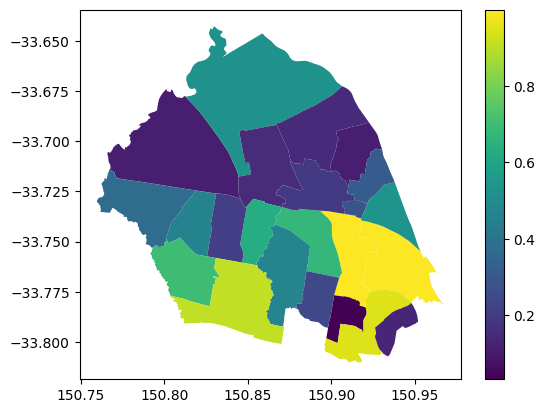

In [76]:
df_scores = gpd.read_postgis(
    "SELECT s.*, sc.score FROM raw.sa2_my s JOIN analysis.sa2_scores sc USING (sa2_code21)",
    engine, geom_col="geometry"
)
df_scores.plot(column="score", cmap="viridis", legend=True)


## 3.6 correlations

In [80]:

with engine.begin() as conn:
    corr_income = conn.exec_driver_sql("""
        SELECT
          corr(sc.score, CAST(i.median_income AS numeric)) AS corr_income
        FROM analysis.sa2_scores AS sc
        JOIN raw.income_my       AS i
          ON sc.sa2_code21 = i.sa2_code21::text;
    """).scalar()

print(f"Pearson correlation between liveability score and median income = {corr_income:.3f}")




Pearson correlation between liveability score and median income = -0.475


In [ ]:


# # 2) List of raw tables to dump
# tables = ["businesses_my", "population_my", "poi_my", "sa2_my", "stops_my","catchments_primary","catchments_secondary"]

# # 3) Loop and dump full CSVs into your Windows directory
# for tbl in tables:
#     df = pd.read_sql_table(tbl, con=engine, schema="raw")
#     out_path = rf"D:\Uni\2025_S1\DATA2001\gsydney\csv\{tbl}.csv"
#     df.to_csv(out_path, index=False)
#     print(f"Wrote full {tbl} → {out_path}")


Wrote full businesses_my → D:\Uni\2025_S1\DATA2001\gsydney\csv\businesses_my.csv
Wrote full population_my → D:\Uni\2025_S1\DATA2001\gsydney\csv\population_my.csv
Wrote full poi_my → D:\Uni\2025_S1\DATA2001\gsydney\csv\poi_my.csv
Wrote full sa2_my → D:\Uni\2025_S1\DATA2001\gsydney\csv\sa2_my.csv
Wrote full stops_my → D:\Uni\2025_S1\DATA2001\gsydney\csv\stops_my.csv
Wrote full catchments_primary → D:\Uni\2025_S1\DATA2001\gsydney\csv\catchments_primary.csv
Wrote full catchments_secondary → D:\Uni\2025_S1\DATA2001\gsydney\csv\catchments_secondary.csv


In [ ]:
# import pandas as pd
# from sqlalchemy import inspect

# insp = inspect(engine)

# rows = []
# for table in insp.get_table_names(schema="raw"):
#     for col in insp.get_columns(table, schema="raw"):
#         rows.append(
#             {
#                 "table": table,
#                 "column": col["name"],
#                 "type": str(col["type"]),
#                 "nullable": col["nullable"],
#             }
#         )

# df_raw = pd.DataFrame(rows).sort_values(["table", "column"])
# # df_raw                          # Jupyter will render an interactive table

# want = ["sa2_my", "businesses_my", "population_my", "income_my", "stops_my", "poi_my"]

# df_raw.query("table.isin(@want)")

,table,column,type,nullable
69,businesses_my,0_to_50k_businesses,BIGINT,True
74,businesses_my,10m_or_more_businesses,BIGINT,True
71,businesses_my,200k_to_2m_businesses,BIGINT,True
72,businesses_my,2m_to_5m_businesses,BIGINT,True
70,businesses_my,50k_to_200k_businesses,BIGINT,True
73,businesses_my,5m_to_10m_businesses,BIGINT,True
65,businesses_my,industry_code,TEXT,True
66,businesses_my,industry_name,TEXT,True
67,businesses_my,sa2_code,BIGINT,True
76,businesses_my,sa2_code21,TEXT,True
